ThinCurr Python Example: Compute current potential from B-norm {#doc_tCurr_torus_mode}
==========
In this example we demonstrate how to compute a current potential from a given B-norm on a toroidal surface. This has application to compute eddy current and sensor reponse to plasma modes.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.meshing import write_ThinCurr_mesh, build_torus_bnorm_grid, build_periodic_mesh, write_periodic_mesh
from OpenFUSIONToolkit.util import build_XDMF

## Create 3D mode model
In most cases the mode will be imported and/or converted from another tool (eg. DCON). However, in this case we will generate a simple mode shape with fixed toroidal and poloidal mode number for a simple torus. Using a simple helper function we define an n=2, m=3 mode on an R=1.0 m, a=0.4 m torus.

In [3]:
def create_circular_bnorm(filename,R0,Z0,a,n,m,npts=200):
    theta_vals = np.linspace(0.0,2*np.pi,npts,endpoint=False)
    with open(filename,'w+') as fid:
        fid.write('{0} {1}\n'.format(npts,n))
        for theta in theta_vals:
            fid.write('{0} {1} {2} {3}\n'.format(
                R0+a*np.cos(theta),
                Z0+a*np.sin(theta),
                np.cos(m*theta),
                np.sin(m*theta)
            ))
# Create n=2, m=3 mode
create_circular_bnorm('tCurr_mode.dat',1.0,0.0,0.4,2,3)

### Generate mesh and ThinCurr input from mode file
We can now create a ThinCurr model from the mode definition file by using \ref OpenFUSIONToolkit.ThinCurr.meshing.build_torus_bnorm_grid "build_torus_bnorm_grid()" to build a uniform grid over one toroidal field period and \ref OpenFUSIONToolkit.ThinCurr.meshing.build_periodic_mesh "build_periodic_mesh()" to build a mesh from the resulting grid. The result is a ThinCurr model, including periodicity mapping information (`r_map`), and the normal field at each mesh vertex for the Real and Imaginary components of the mode (`bnorm`).

In [4]:
ntheta = 40
nphi = 80
r_grid, bnorm, nfp = build_torus_bnorm_grid('tCurr_mode.dat',ntheta,nphi,resample_type='theta',use_spline=False)
lc_mesh, r_mesh, tnodeset, pnodesets, r_map = build_periodic_mesh(r_grid,nfp)

Loading toroidal plasma mode
  filename = tCurr_mode.dat
  N        = 2
  # of pts = 200
  R0       = (1.0000E+00, -1.7087E-17)
  Mode pair sums -7.6050E-15 -2.9976E-15


### Plot resulting mesh

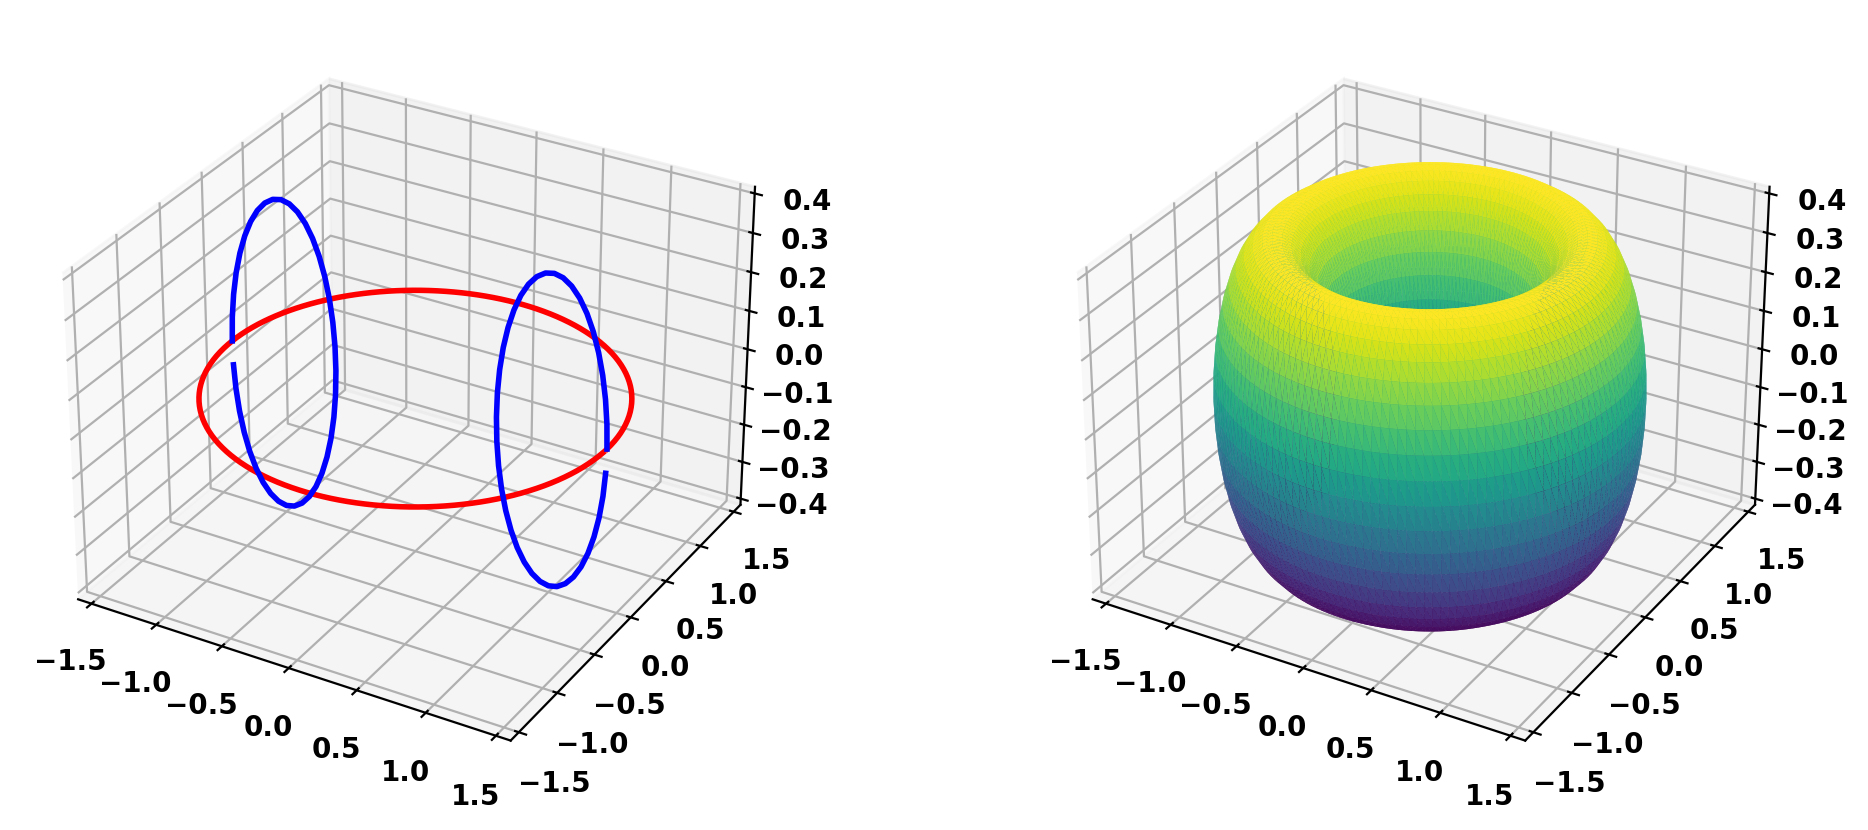

In [5]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot(r_mesh[tnodeset,0], r_mesh[tnodeset,1], r_mesh[tnodeset,2], c='red')
for pnodeset in pnodesets:
    ax.plot(r_mesh[pnodeset,0], r_mesh[pnodeset,1], r_mesh[pnodeset,2], c='blue')

ax = fig.add_subplot(1,2,2, projection='3d')
_ = ax.plot_trisurf(r_mesh[:,0], r_mesh[:,1], r_mesh[:,2], triangles=lc_mesh, cmap='viridis')

### Save model to HDF5 format

In [6]:
write_periodic_mesh('thincurr_mode.h5', r_mesh, lc_mesh+1, np.ones((lc_mesh.shape[0],)),
                    tnodeset, pnodesets, pmap=r_map, nfp=nfp, include_closures=True)


Saving mesh: thincurr_mode.h5


## Compute mode-equivalent current distribution

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html) or [Paraview](https://www.paraview.org/).

In this case we specify a `plasma` directory to use for saving I/O files to keep things separate for the other cases to be run in \ref doc_tCurr_torus_fr.

**Note:** A warning will be generated that no XML node was found and a default resistivity value is being used. This is OK as we will not use the resitivity matrix in this example.

In [7]:
myOFT = OFT_env(nthreads=4)
tw_mode = ThinCurr(myOFT)
tw_mode.setup_model(mesh_file='thincurr_mode.h5')
tw_mode.setup_io(basepath='plasma/')

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   oft_env
Revision id:          f46c10f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_21517/oftpyin                                                                                                                                      
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       12640
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         6320
  # 

### Compute self-inductance matrix
With the model setup, we can now compute the self-inductance matrix. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". For this case we will use the self-inductance to convert between the surface flux $\Phi$ corresponding to the normal field computed above (`bnorm`) and an equivalent surface current 

$\textrm{L} I = \Phi$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

While model definition above handles most of the periodicity, however as pointed out we still end up with `nfp` copies of the poloidal hole. So if `nfp>1` we must condense the self-inductance matrix by summing values over these rows/columns.

Finally, we compute $\textrm{L}^{-1}$.

In [8]:
tw_mode.compute_Lmat()
# Condense model to single mode period
if nfp > 1:
    nelems_new = tw_mode.Lmat.shape[0]-nfp+1
    Lmat_new = np.zeros((nelems_new,nelems_new))
    Lmat_new[:-1,:-1] = tw_mode.Lmat[:-nfp,:-nfp]
    Lmat_new[:-1,-1] = tw_mode.Lmat[:-nfp,-nfp:].sum(axis=1)
    Lmat_new[-1,:-1] = tw_mode.Lmat[-nfp:,:-nfp].sum(axis=0)
    Lmat_new[-1,-1] = tw_mode.Lmat[-nfp:,-nfp:].sum(axis=None)
else:
    Lmat_new = tw_mode.Lmat
# Get inverse
Linv = np.linalg.inv(Lmat_new)

 Building element<->element self inductance matrix
     Time = 19s          


### Compute currents from fluxes and save
Now we can compute the equivalent currents for the Real and Imaginary component of normal field $B_n$ from above. To do this we need to convert to flux $\Phi$ by scaling the field by the area of each vertex using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.scale_vas "scale_va()". As the flux is only given on points we need to supplement those values to the full system size by adding the toroidal and poloidal holes (copying if necessary for `nfp>1`). As a single closure is also needed, we remove the first entry of `flux_flat` as well.

In [9]:
bnorm_flat = bnorm.reshape((2,bnorm.shape[1]*bnorm.shape[2]))
# Get surface flux from normal field
flux_flat = bnorm_flat.copy()
flux_flat[0,r_map] = tw_mode.scale_va(bnorm_flat[0,r_map])
flux_flat[1,r_map] = tw_mode.scale_va(bnorm_flat[1,r_map])
if nfp > 1:
    tw_mode.save_scalar(bnorm_flat[0,r_map],'Bn_c')
    tw_mode.save_scalar(bnorm_flat[1,r_map],'Bn_s')
    output = np.zeros((2,nelems_new+nfp-1))
    for j in range(2):
        output[j,:nelems_new] = np.dot(Linv,np.r_[flux_flat[j,1:-bnorm.shape[2]],0.0,0.0])
        output[j,-nfp+1:] = output[j,-nfp]
else:
    tw_mode.save_scalar(bnorm_flat[0,:],'Bn_c')
    tw_mode.save_scalar(bnorm_flat[1,:],'Bn_s')
    output = np.zeros((2,tw_mode.Lmat.shape[0]))
    for j in range(2):
        output[j,:] = np.dot(Linv,np.r_[flux_flat[j,1:],0.0,0.0])
tw_mode.save_current(output[0,:],'Jc')
tw_mode.save_current(output[1,:],'Js')
tw_mode.build_XDMF()

Removing old Xdmf files
Creating output files


### Plot current potential and mode shape
We now plot the resulting current potential (top) and mode shape (bottom) over a single toroidal mode period to show how the fields are related and ensure no errors.

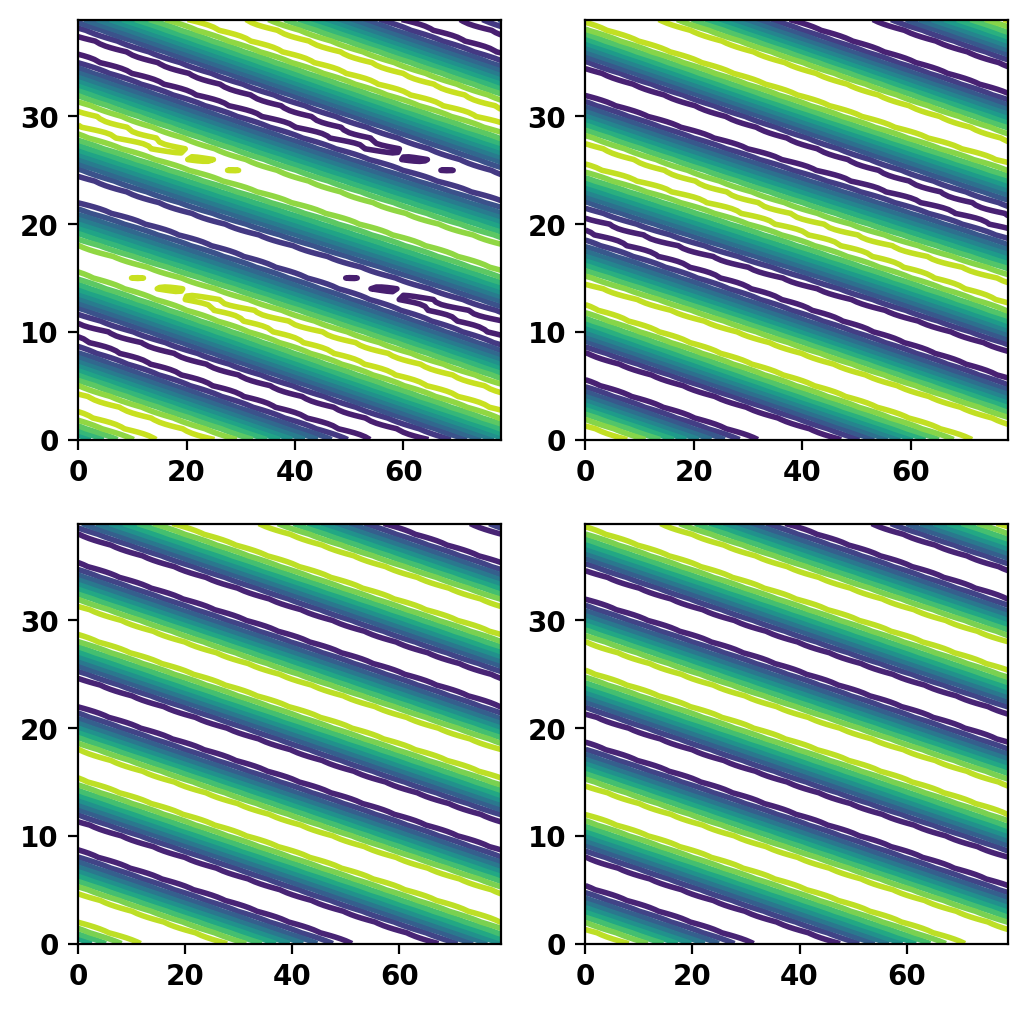

In [10]:
fig, ax = plt.subplots(2,2)
if nfp > 1:
    ax[0,0].contour(np.r_[0.0,output[0,:-nfp-1]].reshape((nphi-1,ntheta)).transpose(),10)
    ax[0,1].contour(np.r_[0.0,output[1,:-nfp-1]].reshape((nphi-1,ntheta)).transpose(),10)
else:
    ax[0,0].contour(np.r_[0.0,output[0,:-nfp-1]].reshape((nphi,ntheta)).transpose(),10)
    ax[0,1].contour(np.r_[0.0,output[1,:-nfp-1]].reshape((nphi,ntheta)).transpose(),10)
ax[1,0].contour(bnorm[0,:,:].transpose(),10)
_ = ax[1,1].contour(bnorm[1,:,:].transpose(),10)

### Save current as a "driver" to HDF5 model file
Finally we save the currents to the model file as a "driver" to utilize in frequency response calculations in \ref doc_tCurr_torus_fr.

In [11]:
with h5py.File('thincurr_mode.h5', 'r+') as h5_file:
    h5_file.create_dataset('thincurr/driver', data=output, dtype='f8')